# Multi-Class Classification of Gravitational Lensing Images

This notebook implements a deep learning model for classifying gravitational lensing images into three classes: "no", "sphere", and "vort".  We use a ResNet18 model pre-trained on ImageNet, and we fine-tune all layers on the lensing dataset.  We also perform a hyperparameter grid search to optimize the learning rates.

**Dataset:** The dataset is available on Google Drive (link provided in the README) and is *not* included in this repository due to its size.  Please follow the instructions in the README to download and prepare the dataset before running this notebook.

**Dependencies:** This notebook requires PyTorch, torchvision, scikit-learn, matplotlib, seaborn, and tqdm.  Install them using `pip install -r requirements.txt`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:

DATA_DIR = "../data"
MODEL_SAVE_PATH = "../models/best_model.pth"
BATCH_SIZE = 32
NUM_EPOCHS = 10  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(f"Using device: {DEVICE}")


Using device: cuda


In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.98, 1.02)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Data Loading and Preprocessing

We use a custom `LensingDataset` class to load the images from the `.npy` files.  The dataset is split into training, validation, and test sets.  Data augmentation is applied to the training set to improve model robustness.

In [5]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["no", "sphere", "vort"]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._make_dataset()
        self.error_counts = {cls_name: 0 for cls_name in self.classes}

    def _make_dataset(self):
        samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            if not os.path.isdir(class_dir):
                continue
            for filename in os.listdir(class_dir):
                if filename.endswith(".npy"):
                    path = os.path.join(class_dir, filename)
                    item = (path, self.class_to_idx[target_class])
                    samples.append(item)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image_np = np.load(img_path)

            if len(image_np.shape) == 3:
                if image_np.shape == (1, 150, 150):
                    image_np = image_np[0]
                elif image_np.shape == (1, 1, 150):
                    square_size = int(np.sqrt(150))
                    image_np = image_np[0, 0, :square_size*square_size].reshape(square_size, square_size)
                    image_np = np.repeat(np.repeat(image_np, 150//square_size, axis=0), 150//square_size, axis=1)
                else:
                    image_np = image_np.reshape(image_np.shape[1], image_np.shape[2])

            if image_np.dtype == np.float64 or image_np.dtype == np.float32:
                image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)
                image_np = (image_np * 255).astype(np.uint8)
            elif image_np.dtype != np.uint8:
                image_np = image_np.astype(np.uint8)

            if len(image_np.shape) == 2:
                image_pil = Image.fromarray(image_np).convert('RGB')
            elif len(image_np.shape) == 3 and image_np.shape[2] == 3:
                image_pil = Image.fromarray(image_np)
            else:
                image_pil = Image.fromarray(image_np).convert('RGB')

            if self.transform:
                image = self.transform(image_pil)
            else:
                image = transforms.ToTensor()(image_pil)
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            self.error_counts[self.classes[label]] += 1
            return torch.zeros((3, 224, 224)), label

    def report_errors(self):
        print("Data loading errors:")
        for cls_name, count in self.error_counts.items():
            print(f"  {cls_name}: {count}")


def collate_fn(batch):
    batch = [item for item in batch if item is not None and item[0] is not None]
    if len(batch) == 0:
        return torch.zeros((0, 3, 224, 224)), torch.zeros(0)
    return torch.utils.data.dataloader.default_collate(batch)

## Model Definition and Training

We use a ResNet18 model pre-trained on ImageNet. We unfreeze all layers for fine-tuning. We use the Adam optimizer with a learning rate scheduler (`ReduceLROnPlateau`).  A grid search is performed to find optimal learning rates for different layer groups.

In [6]:
train_transforms = data_transforms
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LensingDataset(root_dir=os.path.join(DATA_DIR, "dataset", "train"), transform=train_transforms)
val_dataset = LensingDataset(root_dir=os.path.join(DATA_DIR, "dataset", "val"), transform=val_transforms)
test_dataset = LensingDataset(root_dir=os.path.join(DATA_DIR, "dataset", "test"), transform=val_transforms)

train_dataset.report_errors()
val_dataset.report_errors()
test_dataset.report_errors()

print("Training set class distribution:")
for i, cls_name in enumerate(train_dataset.classes):
    count = sum(1 for _, label in train_dataset.samples if label == i)
    print(f"  {cls_name}: {count}")

print("Validation set class distribution:")
for i, cls_name in enumerate(val_dataset.classes):
    count = sum(1 for _, label in val_dataset.samples if label == i)
    print(f"  {cls_name}: {count}")
print("Test set class distribution:")
for i, cls_name in enumerate(test_dataset.classes):
    count = sum(1 for _, label in test_dataset.samples if label == i)
    print(f"  {cls_name}: {count}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)

def get_layer_groups(model):
    layer_groups = [
        list(model.conv1.parameters()) + list(model.bn1.parameters()),  # Early layers
        list(model.layer1.parameters()) + list(model.layer2.parameters()),  # Middle layers
        list(model.layer3.parameters()) + list(model.layer4.parameters()),  # Late layers
        list(model.fc.parameters())  # Fully connected layer
    ]
    return layer_groups

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device, start_epoch=0):
    best_val_auc_run = 0.0
    train_losses = []
    val_losses = []
    train_auc_scores = []
    val_auc_scores = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"Epoch {epoch+1}/{start_epoch + num_epochs}") 

        model.train()
        running_loss = 0.0
        all_labels = []
        all_probs = []
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_probs.extend(probs)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        train_auc_scores.append(train_auc)
        print(f"  Train Loss: {epoch_loss:.4f}  Train AUC: {train_auc:.4f}")

        model.eval()
        running_loss = 0.0
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
                all_probs.extend(probs)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        val_auc_scores.append(val_auc)
        print(f"  Val Loss: {epoch_loss:.4f}    Val AUC: {val_auc:.4f}")

        scheduler.step(epoch_loss)
        if val_auc > best_val_auc_run:
            best_val_auc_run = val_auc

        print(f"  Current Learning Rate: {optimizer.param_groups[0]['lr']}")

    return train_losses, val_losses, train_auc_scores, val_auc_scores


lr_grid = {
    'early': [1e-7, 1e-6],
    'middle': [1e-6, 1e-5],
    'late': [1e-5, 1e-4],
    'fc': [1e-4, 1e-3]
}

best_val_auc = 0.0
best_lrs = {}
start_epoch = 0  


perform_grid_search = True  # Set to True to run grid search

if perform_grid_search:
    if os.path.exists(MODEL_SAVE_PATH):
        print("Loading checkpoint for grid search...")
        checkpoint = torch.load(MODEL_SAVE_PATH)
        best_lrs = checkpoint['best_lrs']
        best_val_auc = checkpoint['best_val_auc']
        print(f"  Loaded best LR: {best_lrs}, Best Val AUC: {best_val_auc}")

    for lr_early in lr_grid['early']:
        for lr_middle in lr_grid['middle']:
            for lr_late in lr_grid['late']:
                for lr_fc in lr_grid['fc']:
                    current_lrs = {'early': lr_early, 'middle': lr_middle, 'late': lr_late, 'fc': lr_fc}

                    if current_lrs == best_lrs:
                        print(f"Skipping already trained LR combination: {current_lrs}")
                        continue

                    print(f"Training with LR: early={lr_early}, middle={lr_middle}, late={lr_late}, fc={lr_fc}")

                    model = models.resnet18(pretrained=True)
                    for param in model.parameters():
                        param.requires_grad = True  # Unfreeze all layers
                    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
                    model = model.to(DEVICE)

                    layer_groups = get_layer_groups(model)
                    optimizer = optim.Adam([
                        {'params': layer_groups[0], 'lr': lr_early},
                        {'params': layer_groups[1], 'lr': lr_middle},
                        {'params': layer_groups[2], 'lr': lr_late},
                        {'params': layer_groups[3], 'lr': lr_fc}
                    ])

                    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False)
                    criterion = nn.CrossEntropyLoss()

                    train_losses, val_losses, train_auc_scores, val_auc_scores = train_model(
                        model, criterion, optimizer, scheduler, train_loader, val_loader, NUM_EPOCHS, DEVICE, start_epoch
                    )

                    current_best_val_auc = max(val_auc_scores)
                    print(f"  Best Validation AUC: {current_best_val_auc:.4f}")

                    if current_best_val_auc > best_val_auc:
                        best_val_auc = current_best_val_auc
                        best_lrs = {'early': lr_early, 'middle': lr_middle, 'late': lr_late, 'fc': lr_fc}
                        print(f"  New best AUC: {best_val_auc:.4f} with LR: {best_lrs}")

                        torch.save({
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler_state_dict': scheduler.state_dict(),
                            'best_lrs': best_lrs,
                            'best_val_auc': best_val_auc,
                            'epoch': NUM_EPOCHS  
                            }, MODEL_SAVE_PATH)

    print(f"Grid Search Complete")
    print(f"Best Learning Rates: {best_lrs}")
    print(f"Best Validation AUC: {best_val_auc:.4f}")

print("\n=== Loading Best Model ===")
if os.path.exists(MODEL_SAVE_PATH):
    print("Loading best model from checkpoint...")
    
    best_model = models.resnet18(pretrained=True)
    best_model.fc = nn.Linear(best_model.fc.in_features, len(train_dataset.classes))
    
    checkpoint = torch.load(MODEL_SAVE_PATH)
    best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model = best_model.to(DEVICE)
    
    best_lrs = checkpoint['best_lrs']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"Best model loaded successfully with:")
    print(f"  Best Learning Rates: {best_lrs}")
    print(f"  Best Validation AUC: {best_val_auc:.4f}")
    
    layer_groups = get_layer_groups(best_model)
    best_optimizer = optim.Adam([
        {'params': layer_groups[0], 'lr': best_lrs['early']},
        {'params': layer_groups[1], 'lr': best_lrs['middle']},
        {'params': layer_groups[2], 'lr': best_lrs['late']},
        {'params': layer_groups[3], 'lr': best_lrs['fc']}
    ])
    
    best_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    best_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        best_optimizer, mode='min', factor=0.1, patience=3, verbose=False)
    
    if 'scheduler_state_dict' in checkpoint:
        best_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    criterion = nn.CrossEntropyLoss()
    
    additional_epochs = 5  
    if additional_epochs > 0:
        print(f"\n=== Continuing Training for {additional_epochs} More Epochs ===")
        start_epoch = checkpoint.get('epoch', 0)
        
        train_losses, val_losses, train_auc_scores, val_auc_scores = train_model(
            best_model, criterion, best_optimizer, best_scheduler, 
            train_loader, val_loader, additional_epochs, DEVICE, start_epoch
        )
        
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': best_optimizer.state_dict(),
            'scheduler_state_dict': best_scheduler.state_dict(),
            'best_lrs': best_lrs,
            'best_val_auc': max(val_auc_scores) if val_auc_scores else best_val_auc,
            'epoch': start_epoch + additional_epochs
        }, MODEL_SAVE_PATH)
        
        print("Updated model saved.")
    
    print("\n=== Evaluating Best Model on Test Set ===")
    best_model.eval()
    test_running_loss = 0.0
    all_test_labels = []
    all_test_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            all_test_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_test_probs.extend(probs)
    
    if len(all_test_labels) > 0:  
        test_loss = test_running_loss / len(test_loader.dataset)
        test_auc = roc_auc_score(all_test_labels, all_test_probs, multi_class='ovr')
        print(f"Test Loss: {test_loss:.4f}  Test AUC: {test_auc:.4f}")
    else:
        print("Test set is empty. Skipping evaluation.")
else:
    print("No saved model found at", MODEL_SAVE_PATH)
    print("Please run grid search first or specify a valid model path.")

Data loading errors:
  no: 0
  sphere: 0
  vort: 0
Data loading errors:
  no: 0
  sphere: 0
  vort: 0
Data loading errors:
  no: 0
  sphere: 0
  vort: 0
Training set class distribution:
  no: 9000
  sphere: 9000
  vort: 9000
Validation set class distribution:
  no: 2500
  sphere: 2500
  vort: 2500
Test set class distribution:
  no: 1000
  sphere: 1000
  vort: 1000
Loading checkpoint for grid search...


  Loaded best LR: {'early': 1e-06, 'middle': 1e-05, 'late': 0.0001, 'fc': 0.001}, Best Val AUC: 0.9781306400000002
Training with LR: early=1e-07, middle=1e-06, late=1e-05, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0976  Train AUC: 0.5515


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0706    Val AUC: 0.6036
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0455  Train AUC: 0.6291


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0311    Val AUC: 0.6556
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0062  Train AUC: 0.6687


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9951    Val AUC: 0.6826
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9749  Train AUC: 0.6952


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9533    Val AUC: 0.7114
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9522  Train AUC: 0.7119


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9233    Val AUC: 0.7334
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9285  Train AUC: 0.7306


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9092    Val AUC: 0.7496
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9093  Train AUC: 0.7431


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8831    Val AUC: 0.7675
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8857  Train AUC: 0.7587


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8715    Val AUC: 0.7779
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8610  Train AUC: 0.7726


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8311    Val AUC: 0.7907
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8402  Train AUC: 0.7853


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8162    Val AUC: 0.7991
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.7991
Training with LR: early=1e-07, middle=1e-06, late=1e-05, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.1078  Train AUC: 0.5539


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0771    Val AUC: 0.6117
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0651  Train AUC: 0.6149


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0359    Val AUC: 0.6659
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0285  Train AUC: 0.6516


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0018    Val AUC: 0.6870
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0004  Train AUC: 0.6792


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9875    Val AUC: 0.6997
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9721  Train AUC: 0.6994


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9656    Val AUC: 0.7341
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9435  Train AUC: 0.7211


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9585    Val AUC: 0.7479
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9246  Train AUC: 0.7336


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9110    Val AUC: 0.7630
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9032  Train AUC: 0.7484


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8950    Val AUC: 0.7768
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8798  Train AUC: 0.7632


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8713    Val AUC: 0.7777
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8586  Train AUC: 0.7756


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8285    Val AUC: 0.7919
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.7919
Training with LR: early=1e-07, middle=1e-06, late=0.0001, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0525  Train AUC: 0.6162


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9701    Val AUC: 0.7030
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9584  Train AUC: 0.7041


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9209    Val AUC: 0.7530
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8977  Train AUC: 0.7482


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8624    Val AUC: 0.7760
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8531  Train AUC: 0.7770


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8334    Val AUC: 0.8027
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8108  Train AUC: 0.7993


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8120    Val AUC: 0.8205
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7676  Train AUC: 0.8231


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7339    Val AUC: 0.8420
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7381  Train AUC: 0.8370


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7174    Val AUC: 0.8527
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6969  Train AUC: 0.8554


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6555    Val AUC: 0.8721
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6800  Train AUC: 0.8625


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6349    Val AUC: 0.8832
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6558  Train AUC: 0.8727


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6332    Val AUC: 0.8843
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.8843
Training with LR: early=1e-07, middle=1e-06, late=0.0001, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0732  Train AUC: 0.6001


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0633    Val AUC: 0.6871
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9754  Train AUC: 0.6927


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9238    Val AUC: 0.7522
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9116  Train AUC: 0.7396


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8695    Val AUC: 0.7853
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8620  Train AUC: 0.7701


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7952    Val AUC: 0.8109
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8168  Train AUC: 0.7956


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7952    Val AUC: 0.8175
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7761  Train AUC: 0.8170


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7444    Val AUC: 0.8443
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7384  Train AUC: 0.8364


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6901    Val AUC: 0.8616
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7109  Train AUC: 0.8495


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7562    Val AUC: 0.8687
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6776  Train AUC: 0.8629


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6457    Val AUC: 0.8791
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6621  Train AUC: 0.8697


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6290    Val AUC: 0.8842
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.8842
Training with LR: early=1e-07, middle=1e-05, late=1e-05, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0856  Train AUC: 0.5695


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0543    Val AUC: 0.6402
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9797  Train AUC: 0.6904


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9018    Val AUC: 0.7543
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8611  Train AUC: 0.7727


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7768    Val AUC: 0.8217
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7594  Train AUC: 0.8277


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6718    Val AUC: 0.8707
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6786  Train AUC: 0.8644


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6236    Val AUC: 0.8953
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6192  Train AUC: 0.8879


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5606    Val AUC: 0.9131
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5775  Train AUC: 0.9027


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5078    Val AUC: 0.9254
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5394  Train AUC: 0.9150


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4925    Val AUC: 0.9339
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5072  Train AUC: 0.9247


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4763    Val AUC: 0.9362
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4794  Train AUC: 0.9334


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4427    Val AUC: 0.9472
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.9472
Training with LR: early=1e-07, middle=1e-05, late=1e-05, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0988  Train AUC: 0.5698


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0656    Val AUC: 0.6428
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0061  Train AUC: 0.6732


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9516    Val AUC: 0.7491
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8956  Train AUC: 0.7516


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8097    Val AUC: 0.8095
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7923  Train AUC: 0.8118


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7109    Val AUC: 0.8576
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7095  Train AUC: 0.8521


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6630    Val AUC: 0.8872
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6363  Train AUC: 0.8814


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5801    Val AUC: 0.9093
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5938  Train AUC: 0.8972


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5237    Val AUC: 0.9240
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5571  Train AUC: 0.9095


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4900    Val AUC: 0.9333
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5257  Train AUC: 0.9194


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4703    Val AUC: 0.9416
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4970  Train AUC: 0.9278


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4443    Val AUC: 0.9467
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.9467
Training with LR: early=1e-07, middle=1e-05, late=0.0001, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0267  Train AUC: 0.6437


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9289    Val AUC: 0.7493
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8376  Train AUC: 0.7853


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7348    Val AUC: 0.8472
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6997  Train AUC: 0.8547


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6522    Val AUC: 0.8841
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6113  Train AUC: 0.8901


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5267    Val AUC: 0.9212
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5476  Train AUC: 0.9123


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4901    Val AUC: 0.9340
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5011  Train AUC: 0.9264


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4820    Val AUC: 0.9368
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4702  Train AUC: 0.9348


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4171    Val AUC: 0.9490
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4405  Train AUC: 0.9426


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4213    Val AUC: 0.9525
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4083  Train AUC: 0.9507


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3573    Val AUC: 0.9615
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3871  Train AUC: 0.9550


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3577    Val AUC: 0.9638
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.9638
Training with LR: early=1e-07, middle=1e-05, late=0.0001, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0426  Train AUC: 0.6341


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9902    Val AUC: 0.7486
  Current Learning Rate: 1e-07
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8485  Train AUC: 0.7794


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7779    Val AUC: 0.8551
  Current Learning Rate: 1e-07
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7000  Train AUC: 0.8541


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5790    Val AUC: 0.9043
  Current Learning Rate: 1e-07
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6079  Train AUC: 0.8916


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5102    Val AUC: 0.9261
  Current Learning Rate: 1e-07
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5444  Train AUC: 0.9130


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4875    Val AUC: 0.9370
  Current Learning Rate: 1e-07
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5009  Train AUC: 0.9264


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4373    Val AUC: 0.9458
  Current Learning Rate: 1e-07
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4641  Train AUC: 0.9365


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3955    Val AUC: 0.9550
  Current Learning Rate: 1e-07
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4393  Train AUC: 0.9425


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3889    Val AUC: 0.9572
  Current Learning Rate: 1e-07
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4107  Train AUC: 0.9498


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3742    Val AUC: 0.9593
  Current Learning Rate: 1e-07
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3905  Train AUC: 0.9544


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3549    Val AUC: 0.9636
  Current Learning Rate: 1e-07
  Best Validation AUC: 0.9636
Training with LR: early=1e-06, middle=1e-06, late=1e-05, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0990  Train AUC: 0.5561


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0663    Val AUC: 0.6053
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0451  Train AUC: 0.6275


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0326    Val AUC: 0.6542
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0030  Train AUC: 0.6710


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9888    Val AUC: 0.6933
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9715  Train AUC: 0.6973


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9415    Val AUC: 0.7215
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9414  Train AUC: 0.7209


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9328    Val AUC: 0.7325
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9115  Train AUC: 0.7421


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8860    Val AUC: 0.7600
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8845  Train AUC: 0.7589


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8772    Val AUC: 0.7687
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8659  Train AUC: 0.7701


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8445    Val AUC: 0.7903
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8470  Train AUC: 0.7802


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8176    Val AUC: 0.8019
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8219  Train AUC: 0.7951


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8345    Val AUC: 0.8034
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.8034
Training with LR: early=1e-06, middle=1e-06, late=1e-05, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.1071  Train AUC: 0.5553


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0637    Val AUC: 0.6172
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0586  Train AUC: 0.6209


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0729    Val AUC: 0.6641
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0226  Train AUC: 0.6581


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9730    Val AUC: 0.7010
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9892  Train AUC: 0.6852


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0026    Val AUC: 0.7160
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9585  Train AUC: 0.7098


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9218    Val AUC: 0.7397
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9413  Train AUC: 0.7236


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9497    Val AUC: 0.7522
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9063  Train AUC: 0.7458


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8869    Val AUC: 0.7710
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8806  Train AUC: 0.7616


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8559    Val AUC: 0.7847
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8618  Train AUC: 0.7730


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8456    Val AUC: 0.7925
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8374  Train AUC: 0.7870


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8465    Val AUC: 0.8012
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.8012
Training with LR: early=1e-06, middle=1e-06, late=0.0001, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0509  Train AUC: 0.6189


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9924    Val AUC: 0.6928
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9578  Train AUC: 0.7050


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9113    Val AUC: 0.7487
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8915  Train AUC: 0.7523


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8364    Val AUC: 0.7953
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8332  Train AUC: 0.7882


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8044    Val AUC: 0.8136
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7846  Train AUC: 0.8131


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8055    Val AUC: 0.8161
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7468  Train AUC: 0.8331


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7003    Val AUC: 0.8590
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7069  Train AUC: 0.8504


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6971    Val AUC: 0.8649
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6772  Train AUC: 0.8634


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6345    Val AUC: 0.8808
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6513  Train AUC: 0.8735


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6165    Val AUC: 0.8907
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6228  Train AUC: 0.8854


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6022    Val AUC: 0.8980
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.8980
Training with LR: early=1e-06, middle=1e-06, late=0.0001, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0741  Train AUC: 0.6017


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0121    Val AUC: 0.6728
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9710  Train AUC: 0.6954


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9663    Val AUC: 0.7417
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9075  Train AUC: 0.7424


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8761    Val AUC: 0.7901
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8447  Train AUC: 0.7802


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8176    Val AUC: 0.8200
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8013  Train AUC: 0.8052


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7690    Val AUC: 0.8368
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7531  Train AUC: 0.8292


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6857    Val AUC: 0.8605
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7134  Train AUC: 0.8477


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6624    Val AUC: 0.8710
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6839  Train AUC: 0.8610


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6632    Val AUC: 0.8749
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6545  Train AUC: 0.8726


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6120    Val AUC: 0.8891
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6296  Train AUC: 0.8825


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5962    Val AUC: 0.8990
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.8990
Training with LR: early=1e-06, middle=1e-05, late=1e-05, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0844  Train AUC: 0.5715


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0405    Val AUC: 0.6396
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.9851  Train AUC: 0.6854


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9165    Val AUC: 0.7534
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8736  Train AUC: 0.7647


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8003    Val AUC: 0.8139
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7710  Train AUC: 0.8215


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7654    Val AUC: 0.8570
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6845  Train AUC: 0.8616


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6500    Val AUC: 0.8906
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6315  Train AUC: 0.8837


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5664    Val AUC: 0.9106
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5760  Train AUC: 0.9030


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5407    Val AUC: 0.9235
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5414  Train AUC: 0.9150


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4817    Val AUC: 0.9364
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5084  Train AUC: 0.9244


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4646    Val AUC: 0.9404
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4790  Train AUC: 0.9333


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4264    Val AUC: 0.9491
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.9491
Training with LR: early=1e-06, middle=1e-05, late=1e-05, fc=0.001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.1030  Train AUC: 0.5620


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 1.0489    Val AUC: 0.6474
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0006  Train AUC: 0.6753


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9224    Val AUC: 0.7514
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8876  Train AUC: 0.7571


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.8265    Val AUC: 0.8148
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.7832  Train AUC: 0.8160


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7017    Val AUC: 0.8623
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6957  Train AUC: 0.8571


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6412    Val AUC: 0.8911
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6470  Train AUC: 0.8776


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5583    Val AUC: 0.9149
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5928  Train AUC: 0.8972


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5363    Val AUC: 0.9236
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5511  Train AUC: 0.9114


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4879    Val AUC: 0.9341
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5236  Train AUC: 0.9197


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4515    Val AUC: 0.9414
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4886  Train AUC: 0.9299


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4819    Val AUC: 0.9461
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.9461
Training with LR: early=1e-06, middle=1e-05, late=0.0001, fc=0.0001
Epoch 1/10


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0327  Train AUC: 0.6361


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9091    Val AUC: 0.7419
  Current Learning Rate: 1e-06
Epoch 2/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8295  Train AUC: 0.7897


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7250    Val AUC: 0.8478
  Current Learning Rate: 1e-06
Epoch 3/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6868  Train AUC: 0.8599


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6108    Val AUC: 0.8964
  Current Learning Rate: 1e-06
Epoch 4/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5993  Train AUC: 0.8946


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5503    Val AUC: 0.9207
  Current Learning Rate: 1e-06
Epoch 5/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5400  Train AUC: 0.9144


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4897    Val AUC: 0.9347
  Current Learning Rate: 1e-06
Epoch 6/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4969  Train AUC: 0.9273


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4455    Val AUC: 0.9456
  Current Learning Rate: 1e-06
Epoch 7/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4601  Train AUC: 0.9375


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4697    Val AUC: 0.9463
  Current Learning Rate: 1e-06
Epoch 8/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4337  Train AUC: 0.9444


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3797    Val AUC: 0.9598
  Current Learning Rate: 1e-06
Epoch 9/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4019  Train AUC: 0.9518


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3872    Val AUC: 0.9582
  Current Learning Rate: 1e-06
Epoch 10/10


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3770  Train AUC: 0.9576


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3326    Val AUC: 0.9671
  Current Learning Rate: 1e-06
  Best Validation AUC: 0.9671
Skipping already trained LR combination: {'early': 1e-06, 'middle': 1e-05, 'late': 0.0001, 'fc': 0.001}
Grid Search Complete
Best Learning Rates: {'early': 1e-06, 'middle': 1e-05, 'late': 0.0001, 'fc': 0.001}
Best Validation AUC: 0.9781

=== Loading Best Model ===
Loading best model from checkpoint...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best model loaded successfully with:
  Best Learning Rates: {'early': 1e-06, 'middle': 1e-05, 'late': 0.0001, 'fc': 0.001}
  Best Validation AUC: 0.9781

=== Continuing Training for 5 More Epochs ===
Epoch 16/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2794  Train AUC: 0.9759


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3066    Val AUC: 0.9762
  Current Learning Rate: 1e-06
Epoch 17/20


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2674  Train AUC: 0.9777


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2530    Val AUC: 0.9816
  Current Learning Rate: 1e-06
Epoch 18/20


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2553  Train AUC: 0.9796


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2569    Val AUC: 0.9808
  Current Learning Rate: 1e-06
Epoch 19/20


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2521  Train AUC: 0.9800


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2265    Val AUC: 0.9836
  Current Learning Rate: 1e-06
Epoch 20/20


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2447  Train AUC: 0.9809


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2452    Val AUC: 0.9833
  Current Learning Rate: 1e-06
Updated model saved.

=== Evaluating Best Model on Test Set ===


Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Test Loss: 0.2192  Test AUC: 0.9870


In [ ]:
def plot_training_history(train_losses, val_losses, train_auc, val_auc):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_auc, 'b-', label='Training AUC')
    plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def plot_roc_curve(labels, probabilities, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        class_labels = [1 if label == i else 0 for label in labels]
        fpr[i], tpr[i], _ = roc_curve(class_labels, [prob[i] for prob in probabilities])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(labels, probabilities, classes):
    preds = np.argmax(probabilities, axis=1)
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Training Using the Grid Search Results
Here we will retrain the model using the optimized parameters that were found


In [9]:
NUM_EPOCHS = 15

train_losses_cont, val_losses_cont, train_auc_scores_cont, val_auc_scores_cont = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, NUM_EPOCHS, DEVICE
)

Epoch 1/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3625  Train AUC: 0.9606


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3620    Val AUC: 0.9673
  Current Learning Rate: 1e-06
Epoch 2/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3418  Train AUC: 0.9649


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2982    Val AUC: 0.9733
  Current Learning Rate: 1e-06
Epoch 3/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3278  Train AUC: 0.9675


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3008    Val AUC: 0.9720
  Current Learning Rate: 1e-06
Epoch 4/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3064  Train AUC: 0.9711


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3440    Val AUC: 0.9725
  Current Learning Rate: 1e-06
Epoch 5/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3021  Train AUC: 0.9718


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2740    Val AUC: 0.9768
  Current Learning Rate: 1e-06
Epoch 6/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2923  Train AUC: 0.9735


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2661    Val AUC: 0.9794
  Current Learning Rate: 1e-06
Epoch 7/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2809  Train AUC: 0.9756


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2747    Val AUC: 0.9797
  Current Learning Rate: 1e-06
Epoch 8/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2658  Train AUC: 0.9777


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2593    Val AUC: 0.9788
  Current Learning Rate: 1e-06
Epoch 9/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2595  Train AUC: 0.9791


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2515    Val AUC: 0.9803
  Current Learning Rate: 1e-06
Epoch 10/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2537  Train AUC: 0.9797


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2427    Val AUC: 0.9822
  Current Learning Rate: 1e-06
Epoch 11/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2401  Train AUC: 0.9818


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2618    Val AUC: 0.9788
  Current Learning Rate: 1e-06
Epoch 12/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2342  Train AUC: 0.9823


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2446    Val AUC: 0.9823
  Current Learning Rate: 1e-06
Epoch 13/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2281  Train AUC: 0.9835


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2422    Val AUC: 0.9841
  Current Learning Rate: 1e-06
Epoch 14/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2217  Train AUC: 0.9840


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2327    Val AUC: 0.9828
  Current Learning Rate: 1e-06
Epoch 15/15


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2178  Train AUC: 0.9846


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2322    Val AUC: 0.9836
  Current Learning Rate: 1e-06


Epoch 1/50


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 1.0434  Train AUC: 0.6330


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.9405    Val AUC: 0.7513
  Current Learning Rate: 1e-06
Epoch 2/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.8375  Train AUC: 0.7849


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.7195    Val AUC: 0.8533
  Current Learning Rate: 1e-06
Epoch 3/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.6903  Train AUC: 0.8580


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.6143    Val AUC: 0.8960
  Current Learning Rate: 1e-06
Epoch 4/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5989  Train AUC: 0.8941


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.5850    Val AUC: 0.9201
  Current Learning Rate: 1e-06
Epoch 5/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.5449  Train AUC: 0.9128


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4713    Val AUC: 0.9357
  Current Learning Rate: 1e-06
Epoch 6/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4942  Train AUC: 0.9285


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4467    Val AUC: 0.9444
  Current Learning Rate: 1e-06
Epoch 7/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4522  Train AUC: 0.9397


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3921    Val AUC: 0.9555
  Current Learning Rate: 1e-06
Epoch 8/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4213  Train AUC: 0.9475


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3602    Val AUC: 0.9633
  Current Learning Rate: 1e-06
Epoch 9/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.4023  Train AUC: 0.9516


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.4417    Val AUC: 0.9575
  Current Learning Rate: 1e-06
Epoch 10/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3766  Train AUC: 0.9576


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3537    Val AUC: 0.9681
  Current Learning Rate: 1e-06
Epoch 11/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3604  Train AUC: 0.9607


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3330    Val AUC: 0.9694
  Current Learning Rate: 1e-06
Epoch 12/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3468  Train AUC: 0.9638


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3378    Val AUC: 0.9707
  Current Learning Rate: 1e-06
Epoch 13/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3235  Train AUC: 0.9684


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3105    Val AUC: 0.9733
  Current Learning Rate: 1e-06
Epoch 14/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3116  Train AUC: 0.9702


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.3320    Val AUC: 0.9724
  Current Learning Rate: 1e-06
Epoch 15/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.3052  Train AUC: 0.9715


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2805    Val AUC: 0.9760
  Current Learning Rate: 1e-06
Epoch 16/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2894  Train AUC: 0.9743


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2757    Val AUC: 0.9771
  Current Learning Rate: 1e-06
Epoch 17/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2844  Train AUC: 0.9748


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2664    Val AUC: 0.9782
  Current Learning Rate: 1e-06
Epoch 18/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2720  Train AUC: 0.9770


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2597    Val AUC: 0.9794
  Current Learning Rate: 1e-06
Epoch 19/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2639  Train AUC: 0.9779


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2464    Val AUC: 0.9805
  Current Learning Rate: 1e-06
Epoch 20/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2530  Train AUC: 0.9799


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2332    Val AUC: 0.9824
  Current Learning Rate: 1e-06
Epoch 21/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2449  Train AUC: 0.9808


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2454    Val AUC: 0.9805
  Current Learning Rate: 1e-06
Epoch 22/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2381  Train AUC: 0.9818


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2613    Val AUC: 0.9829
  Current Learning Rate: 1e-06
Epoch 23/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2321  Train AUC: 0.9829


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2336    Val AUC: 0.9839
  Current Learning Rate: 1e-06
Epoch 24/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2272  Train AUC: 0.9834


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2153    Val AUC: 0.9848
  Current Learning Rate: 1e-06
Epoch 25/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2192  Train AUC: 0.9845


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2219    Val AUC: 0.9840
  Current Learning Rate: 1e-06
Epoch 26/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2151  Train AUC: 0.9851


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2740    Val AUC: 0.9809
  Current Learning Rate: 1e-06
Epoch 27/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2051  Train AUC: 0.9864


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2366    Val AUC: 0.9825
  Current Learning Rate: 1e-06
Epoch 28/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2029  Train AUC: 0.9864


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2169    Val AUC: 0.9850
  Current Learning Rate: 1e-06
Epoch 29/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.2016  Train AUC: 0.9867


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2184    Val AUC: 0.9856
  Current Learning Rate: 1e-06
Epoch 30/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1959  Train AUC: 0.9875


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.2462    Val AUC: 0.9840
  Current Learning Rate: 1e-07
Epoch 31/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1608  Train AUC: 0.9914


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1958    Val AUC: 0.9875
  Current Learning Rate: 1e-07
Epoch 32/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1505  Train AUC: 0.9922


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1974    Val AUC: 0.9878
  Current Learning Rate: 1e-07
Epoch 33/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1448  Train AUC: 0.9927


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1949    Val AUC: 0.9880
  Current Learning Rate: 1e-07
Epoch 34/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1441  Train AUC: 0.9928


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1978    Val AUC: 0.9877
  Current Learning Rate: 1e-07
Epoch 35/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1376  Train AUC: 0.9935


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1884    Val AUC: 0.9883
  Current Learning Rate: 1e-07
Epoch 36/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1321  Train AUC: 0.9938


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1927    Val AUC: 0.9883
  Current Learning Rate: 1e-07
Epoch 37/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1360  Train AUC: 0.9935


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1893    Val AUC: 0.9885
  Current Learning Rate: 1e-07
Epoch 38/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1333  Train AUC: 0.9940


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1966    Val AUC: 0.9877
  Current Learning Rate: 1e-07
Epoch 39/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1283  Train AUC: 0.9942


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1897    Val AUC: 0.9883
  Current Learning Rate: 1e-07
Epoch 40/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1293  Train AUC: 0.9940


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1901    Val AUC: 0.9884
  Current Learning Rate: 1e-07
Epoch 41/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1275  Train AUC: 0.9943


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1877    Val AUC: 0.9884
  Current Learning Rate: 1e-07
Epoch 42/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1246  Train AUC: 0.9946


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1902    Val AUC: 0.9882
  Current Learning Rate: 1e-07
Epoch 43/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1255  Train AUC: 0.9944


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1879    Val AUC: 0.9882
  Current Learning Rate: 1e-07
Epoch 44/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1211  Train AUC: 0.9949


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1901    Val AUC: 0.9889
  Current Learning Rate: 1e-07
Epoch 45/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1199  Train AUC: 0.9948


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1871    Val AUC: 0.9887
  Current Learning Rate: 1e-07
Epoch 46/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1189  Train AUC: 0.9950


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1846    Val AUC: 0.9887
  Current Learning Rate: 1e-07
Epoch 47/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1189  Train AUC: 0.9948


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1909    Val AUC: 0.9881
  Current Learning Rate: 1e-07
Epoch 48/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1155  Train AUC: 0.9951


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1827    Val AUC: 0.9888
  Current Learning Rate: 1e-07
Epoch 49/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1170  Train AUC: 0.9950


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1872    Val AUC: 0.9886
  Current Learning Rate: 1e-07
Epoch 50/50


Training:   0%|          | 0/844 [00:00<?, ?it/s]

  Train Loss: 0.1158  Train AUC: 0.9953


Validation:   0%|          | 0/235 [00:00<?, ?it/s]

  Val Loss: 0.1944    Val AUC: 0.9881
  Current Learning Rate: 1e-07


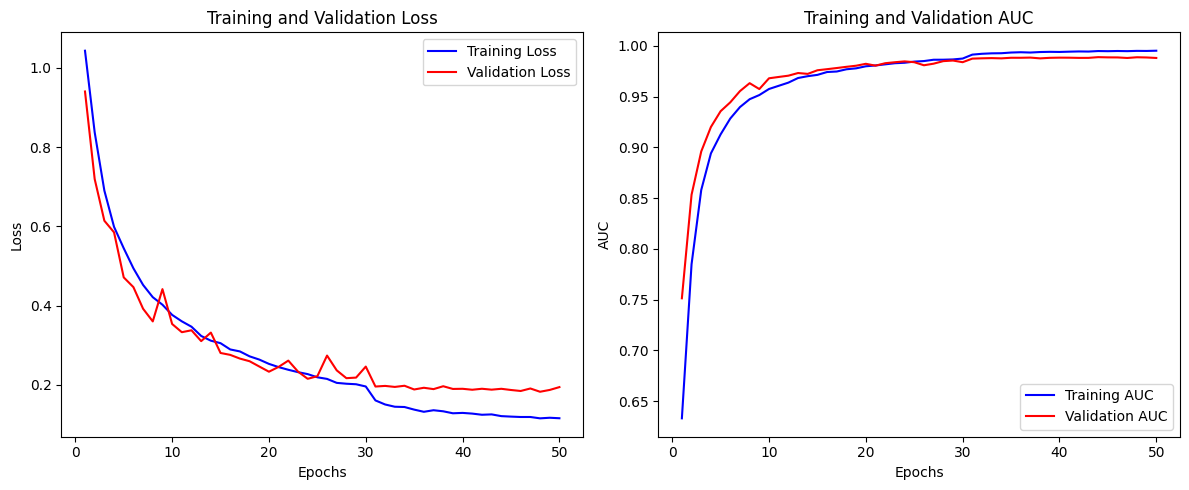

In [10]:
# Cell 10: Final Model Training (with best hyperparameters)
# Train with Best Hyperparameters (After Grid Search)

# Create and train the final model with the *best* learning rates
final_model = models.resnet18(pretrained=True)
for param in final_model.parameters():
    param.requires_grad = True  # Ensure all layers are unfrozen
final_model.fc = nn.Linear(final_model.fc.in_features, len(train_dataset.classes))
final_model = final_model.to(DEVICE)

final_layer_groups = get_layer_groups(final_model)
final_optimizer = optim.Adam([
    {'params': final_layer_groups[0], 'lr': best_lrs['early']},
    {'params': final_layer_groups[1], 'lr': best_lrs['middle']},
    {'params': final_layer_groups[2], 'lr': best_lrs['late']},
    {'params': final_layer_groups[3], 'lr': best_lrs['fc']}
])
final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='min', factor=0.1, patience=5, verbose=True)
final_criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 50  # Set back to a larger number of epochs for final training
final_train_losses, final_val_losses, final_train_auc, final_val_auc = train_model(
    final_model, final_criterion, final_optimizer, final_scheduler, train_loader, val_loader, NUM_EPOCHS, DEVICE
)
plot_training_history(final_train_losses, final_val_losses, final_train_auc, final_val_auc)

In [11]:
def plot_training_history(train_losses, val_losses, train_auc, val_auc):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_auc, 'b-', label='Training AUC')
    plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    best_val_auc_run = 0.0  
    train_losses = []
    val_losses = []
    train_auc_scores = []
    val_auc_scores = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        model.train()
        running_loss = 0.0
        all_labels = []
        all_probs = []
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_probs.extend(probs)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        train_auc_scores.append(train_auc)
        print(f"  Train Loss: {epoch_loss:.4f}  Train AUC: {train_auc:.4f}")

        model.eval()
        running_loss = 0.0
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
                all_probs.extend(probs)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        val_auc_scores.append(val_auc)
        print(f"  Val Loss: {epoch_loss:.4f}    Val AUC: {val_auc:.4f}")

        scheduler.step(epoch_loss)
         # Track best val AUC within the run
        if val_auc > best_val_auc_run:
            best_val_auc_run = val_auc


        print(f"  Current Learning Rate: {optimizer.param_groups[0]['lr']}")

    return train_losses, val_losses, train_auc_scores, val_auc_scores

In [ ]:

import os
import random
import shutil  

DATA_DIR = "../data"
TRAIN_DIR = os.path.join(DATA_DIR, "dataset", "train")
TEST_DIR = os.path.join(DATA_DIR, "dataset", "test")
CLASSES = ["no", "sphere", "vort"]
TEST_SPLIT_RATIO = 0.1  # 10% of the training data will be used for testing


if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    for class_name in CLASSES:
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)
        print(f"Created directory: {os.path.join(TEST_DIR, class_name)}")


for class_name in CLASSES:
    train_class_dir = os.path.join(TRAIN_DIR, class_name)
    test_class_dir = os.path.join(TEST_DIR, class_name)

    filenames = [f for f in os.listdir(train_class_dir) if f.endswith(".npy")]
    num_files = len(filenames)
    num_test_files = int(num_files * TEST_SPLIT_RATIO)

    test_filenames = random.sample(filenames, num_test_files)

    print(f"Moving {num_test_files} files from {train_class_dir} to {test_class_dir}")

    for filename in test_filenames:
        src_path = os.path.join(train_class_dir, filename)
        dest_path = os.path.join(test_class_dir, filename)
        shutil.move(src_path, dest_path)  # Move the file
    print(f"--- Done with class: {class_name} ---")
print("Test set creation complete.")

print("\nVerification:")
for class_name in CLASSES:
  train_count = len([f for f in os.listdir(os.path.join(TRAIN_DIR, class_name)) if f.endswith(".npy")])
  val_count = len([f for f in os.listdir(os.path.join(DATA_DIR, "dataset", "val", class_name)) if f.endswith(".npy")])
  test_count = len([f for f in os.listdir(os.path.join(TEST_DIR, class_name)) if f.endswith(".npy")])
  print(f"Class: {class_name} - Train: {train_count}, Val: {val_count}, Test: {test_count}")

Moving 900 files from ../data/dataset/train/no to ../data/dataset/test/no
--- Done with class: no ---
Moving 900 files from ../data/dataset/train/sphere to ../data/dataset/test/sphere
--- Done with class: sphere ---
Moving 900 files from ../data/dataset/train/vort to ../data/dataset/test/vort
--- Done with class: vort ---
Test set creation complete.

Verification:
Class: no - Train: 8100, Val: 2500, Test: 1900
Class: sphere - Train: 8100, Val: 2500, Test: 1900
Class: vort - Train: 8100, Val: 2500, Test: 1900


## Model Evaluation

The trained model is evaluated on the held-out test set. We report the Test AUC, ROC curve, and confusion matrix.

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Test AUC: 0.9895


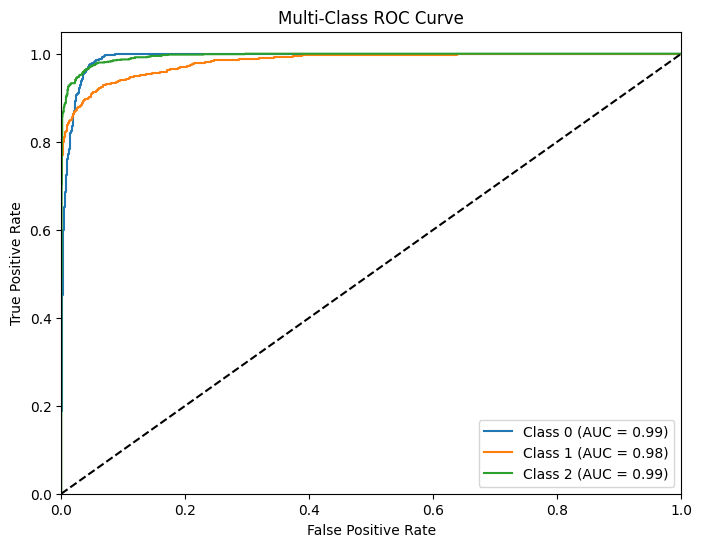

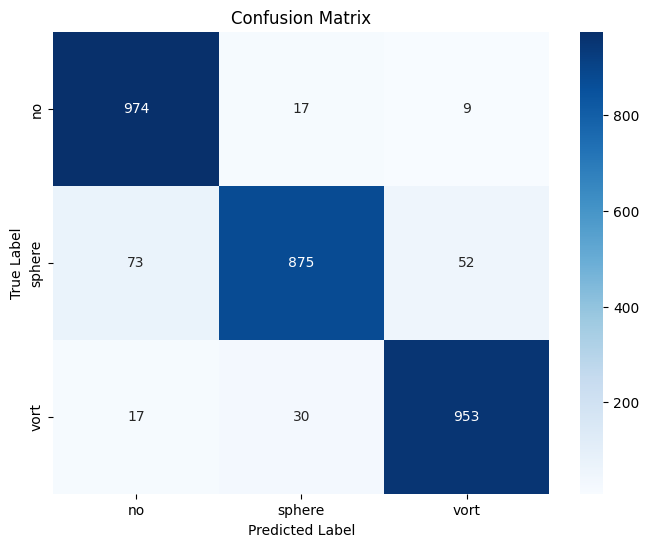

In [ ]:

final_model.eval() 

def evaluate_model(model, data_loader, device):
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    return all_labels, all_probs

test_labels, test_probs = evaluate_model(final_model, test_loader, DEVICE)

if len(test_labels) > 0: 
    test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')
    print(f"Test AUC: {test_auc:.4f}")

    plot_roc_curve(test_labels, test_probs, len(train_dataset.classes))  # Pass num_classes!
    plot_confusion_matrix(test_labels, test_probs, train_dataset.classes)
else:
    print("ERROR: Test set is empty.  Cannot evaluate.")

In [15]:
def plot_roc_curve(labels, probabilities, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        class_labels = [1 if label == i else 0 for label in labels]
        fpr[i], tpr[i], _ = roc_curve(class_labels, [prob[i] for prob in probabilities])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
def plot_confusion_matrix(labels, probabilities, classes):
     preds = np.argmax(probabilities, axis=1)
     cm = confusion_matrix(labels, preds)
     plt.figure(figsize=(8, 6))
     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
     plt.title("Confusion Matrix")
     plt.xlabel("Predicted Label")
     plt.ylabel("True Label")
     plt.show()